In [1]:
from dataclasses import dataclass

import torch
import torch.nn as nn
import math 
import torch.nn.functional as F
from dataclasses import dataclass
from jaxtyping import Float, Int
import matplotlib.pyplot as plt

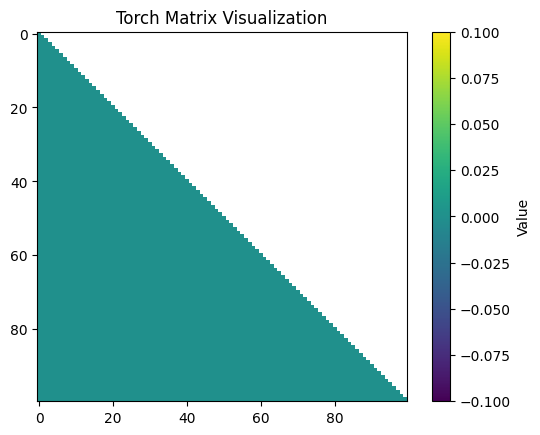

In [2]:
# def create_mask(n_context: int) -> Float[torch.Tensor, "n_context n_context"]:
def create_mask(n_context: int) -> torch.Tensor:
    mask = torch.zeros(n_context, n_context)
    indices = torch.triu_indices(n_context, n_context, offset=1)
    mask[indices[0], indices[1]] = float('-inf')
    
    return mask



# Create a random 5x5 matrix
M = create_mask(100)

# Convert to NumPy for visualization
M_np = M.numpy()

# Plot the matrix
plt.imshow(M_np, cmap='viridis', interpolation='nearest')
plt.colorbar(label="Value")  # Add a color bar
plt.title("Torch Matrix Visualization")
plt.show()

In [29]:
@dataclass
class GPTConfig:
	d_vocab: int = 10_000
	d_model: int = 128
	d_mlp: int = 512
	n_heads: int = 4
	d_head: int = 32
	n_layers: int = 6
	act_fn: type[nn.Module] = nn.ReLU

# note: the residual stream is `n_context` by `d_model`

# this is the row-wise (last dimension) softmax of x
# F.softmax(x, dim=-1)

class AttentionHead(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.W_Q = nn.Linear(cfg.d_model, cfg.d_head)
		self.W_K = nn.Linear(cfg.d_model, cfg.d_head)
		self.W_O = nn.Linear(cfg.d_head, cfg.d_model) # fix this later
		self.W_V = nn.Linear(cfg.d_model, cfg.d_head)
		

		

	def forward(self, x: Int[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
		#hidden = self.embedding(x)
		# n_context = x.size(0)
		# Q = x @ self.W_Q
		# K = x @ self.W_K
		# V = x @ self.W_V
		# scores = Q @ K.T
		# scores = scores / math.sqrt(Q.size(-1))
		# M = create_mask(n_context).to(x.device)
		# scores = scores + M
		# A = F.softmax(scores, dim=-1)
		# head_output = A @ V
		# return head_output @ self.W_O

		M = create_mask(x.size(0))
  
		return F.softmax(self.W_Q(x) @ self.W_K(x).T + M) @ self.W_O(self.W_V(x))
		


class MultiHeadedAttention(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.cfg = cfg
		#List of attention heads
		self.heads = nn.ModuleList([AttentionHead(cfg) for i in range(cfg.n_heads)])

	#def forward(x: Int[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
	def forward(self, x: Int[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
		output = torch.zeros(x.size(0), self.cfg.d_model)
		output += x
		for head in range(self.cfg.n_heads):
			output += self.heads[head].forward(x)
		output += x
		return output
        #Each head returns output of shape [n_context, d_head]
        #Concatenate outputs along the feature dimension: [n_context, n_heads * d_head]
        #Project concatenated outputs back to d_model: [n_context, d_model]




class MLP(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.cfg = cfg
		self.Hidden = nn.Linear(cfg.d_model, cfg.d_mlp)
		self.Output = nn.Linear(cfg.d_mlp, cfg.d_model)
		

	def forward(self, x: Int[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
		output = torch.zeros(x.size(0), self.cfg.d_model)
		n = 0
		for row in x:
			output[n] = self.Output(self.Hidden(row))
			n += 1
		return output



class Transformer(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.cfg = cfg
  
		self.embedding = nn.Embedding(cfg.d_vocab, cfg.d_model)

		self.layers = nn.ModuleList(
			nn.ModuleDict({
				'attn': MultiHeadedAttention(cfg),
				'mlp': MLP(cfg)
			}) for _ in range(cfg.n_layers)
		)
  		
		
		# uses `MultiHeadedAttention` and `MLP`
		# uses nn.Embedding for the embedding, transpose of it for the unembedding

	def forward(self, x: Int[torch.Tensor, "n_context"]) -> Float[torch.Tensor, "n_context d_vocab"]:
     
		# x is a sequence of token ids, shape (n_context,)
		# we need to embed it, then pass it through the transformer layers
		# then we need to unembed it
		# the output of the transformer layers is a sequence of vectors, shape (n_context, d_model)
		# the unembedding layer is a linear layer that maps from d_model to d_vocab
		# the output of the unembedding layer is a sequence of logits, shape (n_context, d_vocab)
		# the logits are the output of the model, we return them
  
		x = self.embedding(x) # shape (n_context, d_model)
		
		for layer in self.layers:
			attn_out = layer['attn'](x)
			x += attn_out
			mlp_out = layer['mlp'](x)
			x += mlp_out
		return x

In [30]:
cfg = GPTConfig()
n_context = 10
x = torch.randint(0, cfg.d_vocab, (n_context,))

In [31]:
transform = Transformer(cfg)
print(x)
print(transform(x))
# print(attn(x))
# print(mh_attn(x))

tensor([3217, 9705, 1080, 7670, 6420, 2640, 1231, 6407, 5313, 3734])
tensor([[  887.1130,   804.9051,  -712.5801,  ..., -1227.6079,   452.8638,
         -2073.2625],
        [-2547.4316,    91.0179,   991.4108,  ..., -2724.6533, -1330.2278,
          -267.2502],
        [ -628.3389,   553.0962,  1337.5000,  ...,  -175.0631,  -870.3667,
           186.5151],
        ...,
        [  256.4483, -1314.9609,  1149.8230,  ...,  -853.0943,  -696.0122,
          1754.4371],
        [ 1042.7755, -2645.4905, -1689.0719,  ...,    -4.6450,   438.5402,
          1820.1376],
        [-1652.3508,  -394.5991,   743.4655,  ...,   196.7555, -1920.0504,
           542.8179]], grad_fn=<AddBackward0>)


/tmp/ipykernel_884716/205275189.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.W_Q(x) @ self.W_K(x).T + M) @ self.W_O(self.W_V(x))


torch.Size([10, 128])
torch.Size([10, 128])


/tmp/ipykernel_884716/205275189.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.W_Q(x) @ self.W_K(x).T + M) @ self.W_O(self.W_V(x))


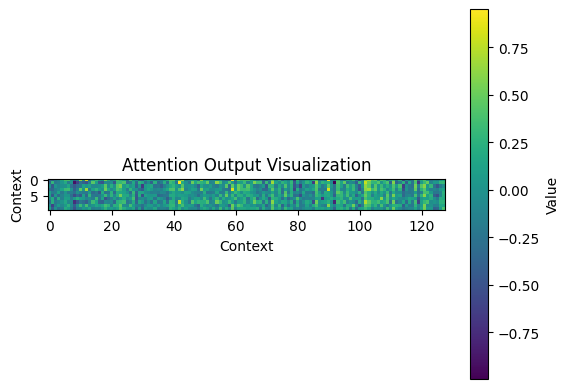

In [32]:
cfg = GPTConfig()

ah = AttentionHead(cfg)
x = torch.randn(10, cfg.d_model)
print(ah(x).shape)

output = ah.forward(x)
print(output.shape)


# visualize the attention scores
plt.imshow(output.detach().numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar(label="Value")  # Add a color bar
plt.title("Attention Output Visualization")
plt.xlabel("Context")
plt.ylabel("Context")
plt.show()
# visualize the attention scores
